Problem statement:
    
    Project is more about exploration, feature engineering and classification that can be done on this data, data set is huge and includes many categories of comments,
    Need to build a model that can differentiate between comments and its categories.,


In [475]:
#loading dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings # Ignores any warning
warnings.filterwarnings("ignore")

import sys
import re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import tensorflow as tf

In [476]:
#instanciating lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [477]:
#creating function to clean data (regex)
def clean_text(text):
    
    data = re.sub('[^a-zA-Z]', ' ', text)
    data = data.lower()
    data = data.split()
    data = [lemmatizer.lemmatize(word) for word in data if word not in stop_words]
    
    return ' '.join(data)

In [478]:
#initiating values
max_seq_len = 100
max_vocab_size = 20000
embedding_dim = 100
validation_split = 0.2
batch_size = 64
epochs = 50

In [479]:
#loading glove repository
word_embeddings = {}
with open('C:/Users/ABHISHEK/Malignant-Comments-Classifier-Project--1-/Malignant Comments Classifier Project/glove.6B.100d.txt/glove.6B.100d.txt',encoding="utf8") as f:
    for line in f:
        values = line.split()
        word_key = values[0]
        word_vector = np.array(values[1:], dtype='float32')
        
        word_embeddings[word_key] = word_vector

In [480]:
#Loading training dataset
train_df = pd.read_csv("train.csv")

In [481]:
#seperating data for measuring count categories
df_toxic = train_df.drop(['id', 'comment_text'], axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats


,category,number_of_comments
0,malignant,15294
1,highly_malignant,1595
2,rude,8449
3,threat,478
4,abuse,7877
5,loathe,1405


Text(0.5, 0, 'category')

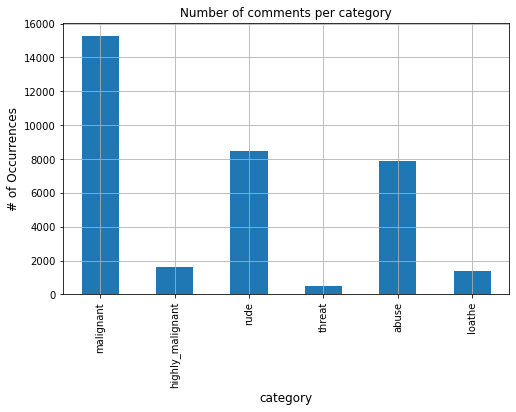

In [482]:
#visual representation for categories
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

In [483]:
train_df

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [484]:
#traning data info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


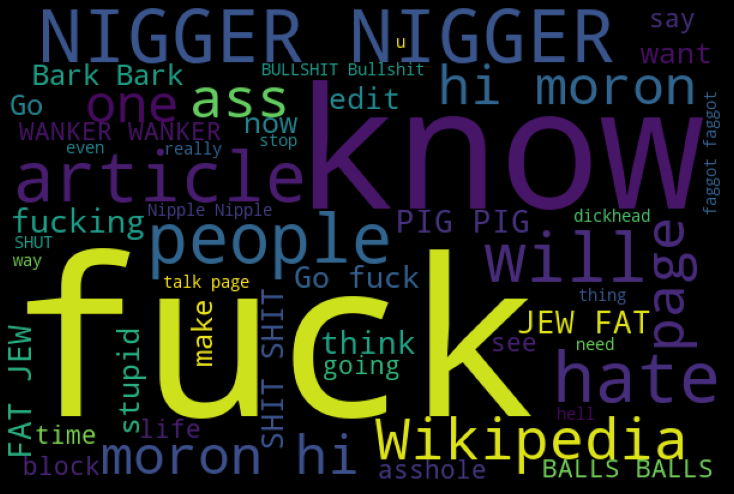

In [485]:

#Getting sense of loud words which are offensive


from wordcloud import WordCloud
hams = train_df['comment_text'][train_df['malignant']==1]
spam_cloud = WordCloud(width=600,height=400,background_color='black',max_words=50).generate(' '.join(hams))
plt.figure(figsize=(10,8),facecolor='k')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [486]:
#cleaning training dataset
documents = train_df.comment_text
documents = [clean_text(doc) for doc in documents]
documents = np.array(documents)
targets = train_df[train_df.columns[2:]].values
documents


array(['explanation edits made username hardcore metallica fan reverted vandalism closure gas voted new york doll fac please remove template talk page since retired',
       'aww match background colour seemingly stuck thanks talk january utc',
       'hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info',
       ...,
       'spitzer umm there actual article prostitution ring crunch captain',
       'look like actually put speedy first version deleted look',
       'really think understand came idea bad right away kind community go bad idea go away instead helping rewrite'],
      dtype='<U5000')

In [487]:
doc_len_list = [len(d) for d in documents]
max_doc_len = max(doc_len_list)
min_doc_len = min(doc_len_list)
avg_doc_len = sum(doc_len_list)/len(documents)

print(f'max document length: {max_doc_len}')
print(f'min document length: {min_doc_len}')
print(f'Avg document length: {avg_doc_len}')

max document length: 5000
min document length: 0
Avg document length: 243.26777421962638


<function matplotlib.pyplot.show(close=None, block=None)>

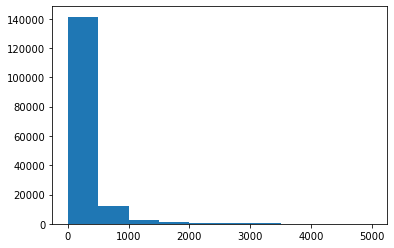

In [488]:
plt.hist(doc_len_list)
plt.show

In [489]:
#tokenizing the training dataset(comment column)
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(documents)
sequences = tokenizer.texts_to_sequences(documents)

In [490]:
word_index

{'article': 1,
 'page': 2,
 'wikipedia': 3,
 'talk': 4,
 'one': 5,
 'please': 6,
 'would': 7,
 'like': 8,
 'source': 9,
 'see': 10,
 'think': 11,
 'also': 12,
 'know': 13,
 'time': 14,
 'people': 15,
 'user': 16,
 'edit': 17,
 'use': 18,
 'make': 19,
 'may': 20,
 'image': 21,
 'get': 22,
 'say': 23,
 'thanks': 24,
 'need': 25,
 'name': 26,
 'link': 27,
 'even': 28,
 'good': 29,
 'want': 30,
 'well': 31,
 'information': 32,
 'way': 33,
 'could': 34,
 'u': 35,
 'comment': 36,
 'deletion': 37,
 'go': 38,
 'editor': 39,
 'section': 40,
 'question': 41,
 'help': 42,
 'thing': 43,
 'first': 44,
 'wp': 45,
 'fact': 46,
 'new': 47,
 'look': 48,
 'work': 49,
 'point': 50,
 'editing': 51,
 'fuck': 52,
 'discussion': 53,
 'right': 54,
 'edits': 55,
 'thank': 56,
 'made': 57,
 'many': 58,
 'much': 59,
 'used': 60,
 'really': 61,
 'find': 62,
 'take': 63,
 'reference': 64,
 'deleted': 65,
 'read': 66,
 'list': 67,
 'add': 68,
 'since': 69,
 'change': 70,
 'someone': 71,
 'reason': 72,
 'policy': 73

In [491]:

word_index = tokenizer.word_index
len(word_index)

158697

In [492]:
seq_data = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_seq_len)
seq_data.shape


(159571, 100)

In [493]:
seq_data

array([[    0,     0,     0, ...,     2,    69,  2934],
       [    0,     0,     0, ...,     4,   823,   101],
       [    0,     0,     0, ...,  2077,   600,   345],
       ...,
       [    0,     0,     0, ...,  2436, 11348,  3538],
       [    0,     0,     0, ...,   227,    65,    48],
       [    0,     0,     0, ...,   252,  1401,  1661]])

In [494]:
num_words = min(max_vocab_size, len(word_index)+1)
num_words

20000

In [495]:
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, idx in word_index.items():
    if idx < max_vocab_size:
        embedding_vector = word_embeddings.get(word)
        
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

In [496]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.55660999, -0.11523   ,  0.32071999, ..., -1.15799999,
         0.58295   ,  0.34836999],
       [-0.92940003,  0.10925   , -0.021222  , ..., -0.92944002,
         0.63875002,  0.38077   ],
       ...,
       [ 0.37322   ,  0.16511001,  0.17619   , ..., -0.12885   ,
        -0.086522  ,  0.27818999],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.17038   , -0.49039   ,  0.12893   , ..., -0.1507    ,
        -0.22002999,  0.61094999]])

In [497]:
print(f'shape of the seq_data: {seq_data.shape}')
print(f'shape of the targets: {targets.shape}')
print(f'shape of the embedding_matrix: {embedding_matrix.shape}')

shape of the seq_data: (159571, 100)
shape of the targets: (159571, 6)
shape of the embedding_matrix: (20000, 100)


In [498]:
embedding_layer = tf.keras.layers.Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False)

In [499]:
input_ = tf.keras.Input(shape=(max_seq_len,))
x = embedding_layer(input_)

In [500]:
#using Bidirectional long-short term memory(bi-lstm) 
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True))(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
output_ = tf.keras.layers.Dense(6, activation='sigmoid')(x)
model = tf.keras.Model(inputs=input_, outputs=output_)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=5, 
    restore_best_weights=True,
)

In [501]:
#calling model 
history = model.fit(seq_data, targets, batch_size=batch_size, epochs= epochs, validation_split=validation_split, callbacks=[early_stopping])

Epoch 1/50
1995/1995 [==============================] - 147s 70ms/step - loss: 0.0647 - accuracy: 0.9801 - val_loss: 0.0542 - val_accuracy: 0.9925
Epoch 2/50
1995/1995 [==============================] - 144s 72ms/step - loss: 0.0501 - accuracy: 0.9858 - val_loss: 0.0504 - val_accuracy: 0.9926
Epoch 3/50
1995/1995 [==============================] - 137s 69ms/step - loss: 0.0460 - accuracy: 0.9831 - val_loss: 0.0485 - val_accuracy: 0.9836
Epoch 4/50
1995/1995 [==============================] - 142s 71ms/step - loss: 0.0429 - accuracy: 0.9829 - val_loss: 0.0495 - val_accuracy: 0.9933
Epoch 5/50
1995/1995 [==============================] - 142s 71ms/step - loss: 0.0406 - accuracy: 0.9822 - val_loss: 0.0482 - val_accuracy: 0.9814
Epoch 6/50
1995/1995 [==============================] - 133s 66ms/step - loss: 0.0384 - accuracy: 0.9863 - val_loss: 0.0488 - val_accuracy: 0.9923
Epoch 7/50
1995/1995 [==============================] - 127s 64ms/step - loss: 0.0363 - accuracy: 0.9819 - val_loss: 0

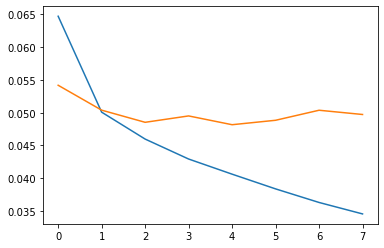

In [502]:
#plot of loss and val loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

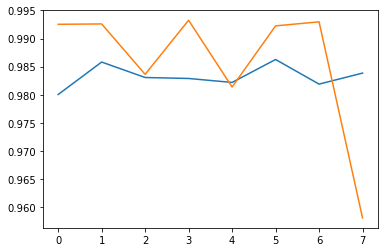

In [503]:
#plot of accuracy and val accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [504]:
#Loading and working on test data
test_df = pd.read_csv('test.csv')
test_data = test_df.comment_text
test_data = [clean_text(doc) for doc in test_data]
test_data = np.array(test_data)
test_ids = test_df.id.values
test_df

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [505]:
#running model on test dataset
test_sequences = tokenizer.texts_to_sequences(test_data)
test_seq_data = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_seq_len)
preds = model.predict(test_seq_data)
preds

array([[9.9193865e-01, 3.4611493e-01, 9.7644627e-01, 9.0411276e-02,
        9.0371895e-01, 5.6482613e-01],
       [1.1424124e-03, 1.0577592e-05, 4.0233135e-04, 3.2896949e-06,
        4.2384863e-04, 2.5151301e-05],
       [1.3302714e-02, 2.7760863e-04, 3.9836168e-03, 1.7103553e-04,
        4.7112107e-03, 3.2621622e-04],
       ...,
       [1.9764900e-04, 1.5004276e-06, 3.5561246e-05, 2.2388886e-06,
        5.2073818e-05, 3.8931903e-06],
       [3.7757754e-03, 2.8362174e-05, 5.0342083e-04, 2.8304647e-05,
        8.8948011e-04, 1.4314950e-03],
       [9.5368880e-01, 1.7436951e-02, 8.4363872e-01, 2.0282567e-03,
        4.4859812e-01, 3.5022497e-03]], dtype=float32)

In [506]:
preds.shape

(153164, 6)

In [507]:
test_ids.shape

(153164,)

In [508]:
#prediction output
test_ids = test_ids.reshape(-1, 1)
preed = pd.DataFrame(preds, columns=train_df.columns[2:])
preed

,malignant,highly_malignant,rude,threat,abuse,loathe
0,0.991939,0.346115,0.976446,0.090411,0.903719,0.564826
1,0.001142,0.000011,0.000402,0.000003,0.000424,0.000025
2,0.013303,0.000278,0.003984,0.000171,0.004711,0.000326
3,0.000443,0.000008,0.000247,0.000004,0.000174,0.000006
4,0.002223,0.000029,0.000637,0.000036,0.000547,0.000022
...,...,...,...,...,...,...
153159,0.570143,0.003021,0.223142,0.003180,0.073208,0.000768
153160,0.090632,0.002141,0.034744,0.004263,0.021716,0.003273
153161,0.000198,0.000002,0.000036,0.000002,0.000052,0.000004
153162,0.003776,0.000028,0.000503,0.000028,0.000889,0.001431


In [509]:
preed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   malignant         153164 non-null  float32
 1   highly_malignant  153164 non-null  float32
 2   rude              153164 non-null  float32
 3   threat            153164 non-null  float32
 4   abuse             153164 non-null  float32
 5   loathe            153164 non-null  float32
dtypes: float32(6)
memory usage: 3.5 MB


In [510]:
preed=preed.round()
preed=preed.astype(int)


In [511]:
#processing prediction to get readable output
preed['id'] = test_ids
preed['comment_text']=test_data

In [512]:
preed

,malignant,highly_malignant,rude,threat,abuse,loathe,id,comment_text
0,1,0,1,0,1,1,00001cee341fdb12,yo bitch ja rule succesful ever whats hating s...
1,0,0,0,0,0,0,0000247867823ef7,rfc title fine imo
2,0,0,0,0,0,0,00013b17ad220c46,source zawe ashton lapland
3,0,0,0,0,0,0,00017563c3f7919a,look back source information updated correct f...
4,0,0,0,0,0,0,00017695ad8997eb,anonymously edit article
...,...,...,...,...,...,...,...,...
153159,1,0,0,0,0,0,fffcd0960ee309b5,totally agree stuff nothing long crap
153160,0,0,0,0,0,0,fffd7a9a6eb32c16,throw field home plate get faster throwing cut...
153161,0,0,0,0,0,0,fffda9e8d6fafa9e,okinotorishima category see change agree corre...
153162,0,0,0,0,0,0,fffe8f1340a79fc2,one founding nation eu germany law return quit...


In [513]:
#readable output in train dataset format
cols = preed.columns.tolist()
cols = cols[-1:] + cols[:-1]
cols = cols[-1:] + cols[:-1]
preed = sub_df[cols]
preed

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,00001cee341fdb12,yo bitch ja rule succesful ever whats hating s...,1,0,1,0,1,0
1,0000247867823ef7,rfc title fine imo,0,0,0,0,0,0
2,00013b17ad220c46,source zawe ashton lapland,0,0,0,0,0,0
3,00017563c3f7919a,look back source information updated correct f...,0,0,0,0,0,0
4,00017695ad8997eb,anonymously edit article,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,totally agree stuff nothing long crap,1,0,0,0,0,0
153160,fffd7a9a6eb32c16,throw field home plate get faster throwing cut...,0,0,0,0,0,0
153161,fffda9e8d6fafa9e,okinotorishima category see change agree corre...,0,0,0,0,0,0
153162,fffe8f1340a79fc2,one founding nation eu germany law return quit...,0,0,0,0,0,0


In [514]:
#Saving prediction dataset
preed.to_csv('PRE.csv', index=False, header=True)